In [1]:
from models.detector_model.my_yolo import YOLO, YOLOTrainingProcessor, COCOProcessor, YOLODataset
from torch.utils.data import DataLoader

grouped_classes = {
        "Metal": [
            "Metal bottle cap", "Metal lid", "Drink can", "Pop tab", "Scrap metal",
            "Food Can", "Aluminium blister pack", "Aluminium foil", "Aerosol"
        ],
        "Plastic": [
            "Plastic bottle cap", "Other plastic wrapper", "Six pack rings",
            "Single-use carrier bag", "Plastic straw", "Plastic glooves",
            "Plastic utensils", "Disposable plastic cup", "Other plastic bottle",
            "Tupperware", "Spread tub", "Garbage bag", "Other plastic container",
            "Other plastic", "Rope & strings", "Other plastic cup", "Plastic film",
            "Polypropylene bag", "Plastic lid", "Clear plastic bottle", "Squeezable tube",
            "Carded blister pack", "Crisp packet", "Meal carton"
        ],
        "Paper": [
            "Paper cup", "Paper bag", "Normal paper", "Paper straw", "Tissues",
            "Toilet tube", "Wrapping paper", "Pizza box", "Magazine paper",
            "Corrugated carton", "Egg carton", "Other carton", "Drink carton"
        ],
        "Glass": [
            "Glass jar", "Glass bottle", "Glass cup", "Broken glass"
        ],
        "Waste": [
            "Cigarette", "Food waste", "Foam cup",
            "Disposable food container", "Foam food container",
            "Shoe", "Unlabeled litter", "Styrofoam piece"
        ],
        "Battery": [
            "Battery"
        ],
    }

In [2]:
model = YOLO(num_classes=len(grouped_classes), num_anchors=4, grid_size=4)
model.count_parameters()
coco_processor = COCOProcessor(classes=grouped_classes)

MODEL PARAMETER SUMMARY
Total parameters:      390,700
Trainable parameters:  390,700
Non-trainable params:  0


In [3]:
extracted_trash = coco_processor.extract_annotations(
    'D:/Sakal/AI_FARM/Recycling_Classification/Dataset/Dataset/Trash Detection.v14i.coco/train/_annotations.coco.json',
    'D:/Sakal/AI_FARM/Recycling_Classification/Dataset/Dataset/Trash Detection.v14i.coco/train',
    convert=False
)

extracted_taco = coco_processor.extract_annotations(
    'D:/Sakal/AI_FARM/Recycling_Classification/Dataset/TACO/data/annotations.json',
    'D:/Sakal/AI_FARM/Recycling_Classification/Dataset/TACO/data',
    convert=True
)

classes_names_trash = []
for label in extracted_trash:
    classes_names_trash.extend(label['Class'])
classes_names_trash = list(set(classes_names_trash))

classes_names_taco = []
for label in extracted_taco:
    classes_names_taco.extend(label['Class'])
classes_names_taco = list(set(classes_names_taco))

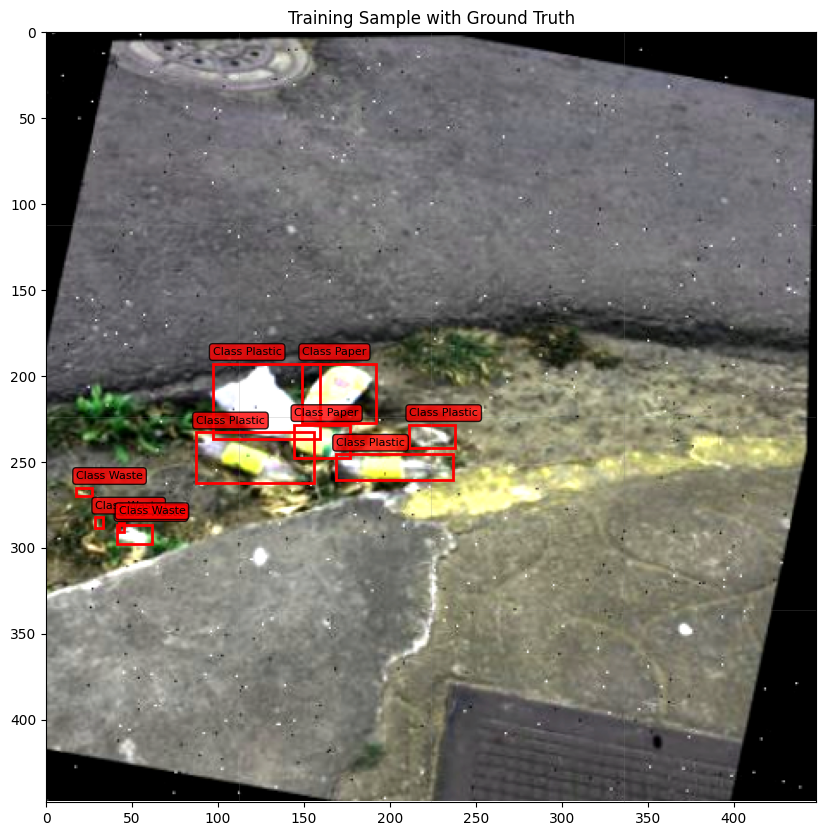

In [4]:
classes = [item for item, value in grouped_classes.items()] # ['Metal', 'Plastic', 'Paper', 'Glass', 'Waste', 'Battery']

processor = YOLOTrainingProcessor(
    input_size=448,
    grid_size=4,
    classes=classes,
    num_anchors=4
)

trash_dataset = YOLODataset(data_json=extracted_trash, processor=processor, is_training=True)
trash_dataloader = DataLoader(trash_dataset, batch_size=25, shuffle=True)

image_tensor, target_tensor, anchor_pose = processor.process_training_sample(
    extracted_trash[90], apply_augmentation=True, get_anchors=True)

processor.visualize_training_sample(
    image_tensor, target_tensor, anchor_pose,)

In [5]:
first_batch = next(iter(trash_dataloader))

# If it's an image and label pair:
images, labels = first_batch

In [6]:
bboxes = processor.convert_yolo_output_to_bboxes(labels[0])
bboxes

[{'bbox': [333.84615355730057,
   7.538461089134216,
   13.555230975151062,
   23.406922578811646],
  'conf': 1.0,
  'class_id': 1},
 {'bbox': [362.92307740449905,
   31.23076903820038,
   8.111384749412537,
   12.444922685623169],
  'conf': 1.0,
  'class_id': 1},
 {'bbox': [226.15384769439697,
   185.2307665348053,
   112.11092376708984,
   55.40769338607788],
  'conf': 1.0,
  'class_id': 4},
 {'bbox': [244.4615397453308,
   118.46153807640076,
   35.444769859313965,
   38.66692304611206],
  'conf': 1.0,
  'class_id': 1},
 {'bbox': [351.0769238471985,
   153.9999966621399,
   37.33369159698486,
   49.18523120880127],
  'conf': 1.0,
  'class_id': 1},
 {'bbox': [102.30769205093384,
   199.23076903820038,
   55.333385944366455,
   67.5553846359253],
  'conf': 1.0,
  'class_id': 4},
 {'bbox': [173.38461756706238,
   231.53846192359924,
   22.333231449127197,
   26.51815366744995],
  'conf': 1.0,
  'class_id': 1},
 {'bbox': [107.69230794906616,
   257.38461673259735,
   28.33384609222412,


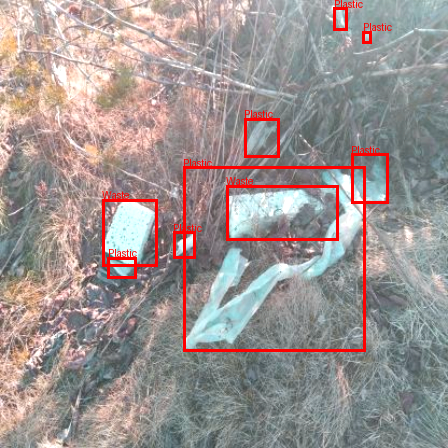

In [15]:
i=0
bboxes = processor.convert_yolo_output_to_bboxes(labels[i])
processor.draw_bbox_on_image(images[i], bboxes, show=False)

In [8]:
bboxes[0]['class_id']

0